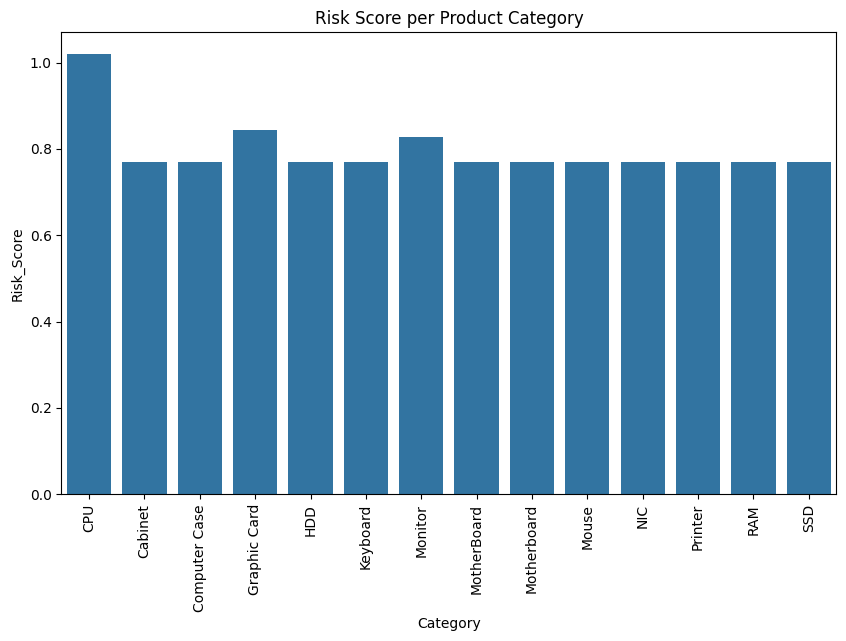


Product categories with the highest risk of anomalies:
        Category  Anomaly  Risk_Score
0            CPU      150    1.019231
3   Graphic Card       33    0.842564
6        Monitor       44    0.827976
1        Cabinet        0    0.769231
2  Computer Case        0    0.769231


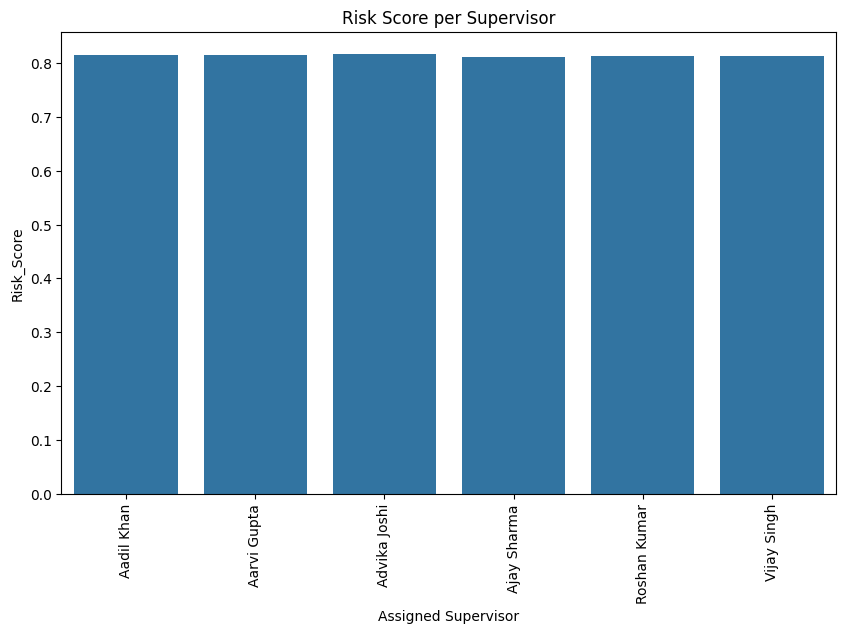

Supervisors with the highest risk of anomalies:
  Assigned Supervisor  Anomaly  Risk_Score
2        Advika Joshi       38    0.817271
1         Aarvi Gupta       44    0.814732
0          Aadil Khan       36    0.814400
5         Vijay Singh       35    0.813311
4        Roshan Kumar       35    0.813090

Products with the highest risk of anomalies:
                         Product  Anomaly  Risk_Score
1068  I7 - intel 12th Generation      150    1.769231
371              26" LCD Display       44    1.062564
641             4GB Graphic card       33    0.989231
0                       1 TB SSD        0    0.769231
817                   619 GB M.2        0    0.769231


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = r"C:\Users\91924\Desktop\MY WORKS\sem 7\forensic\project.csv"
df = pd.read_csv(file_path)
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True) 

df = df.dropna()  # Remove missing values

# Feature Engineering
# Calculate profit margin as a basic financial metric
df['Profit'] = df['Total_Sales'] - df['Total_Cost']
df['Profit_Margin'] = df['Profit'] / df['Total_Sales']

# Grouping Supervisor performance based on the total sales and profit margin
supervisor_performance = df.groupby('Assigned Supervisor').agg({
    'Total_Sales': 'sum',
    'Profit_Margin': 'mean',
    'Order_Number': 'count'
}).rename(columns={'Order_Number': 'Total_Orders'}).reset_index()

# Merge supervisor performance back to the main dataframe
df = pd.merge(df, supervisor_performance, on='Assigned Supervisor', how='left', suffixes=('', '_supervisor'))

# Anomaly detection using Isolation Forest
features = ['Total_Sales', 'Profit_Margin', 'Cost', 'Quantity']  # Financial metrics
X = df[features]

# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(X)

# Mark anomalies
df['Anomaly'] = df['Anomaly_Score'].apply(lambda x: 1 if x == -1 else 0)

# Risk Score: Combine supervisor performance with anomaly detection
df['Risk_Score'] = df['Anomaly'] + (1 - df['Profit_Margin_supervisor'])

# Supervisor-level risk aggregation
supervisor_risk = df.groupby('Assigned Supervisor').agg({
    'Anomaly': 'sum',  
    'Risk_Score': 'mean'
}).reset_index()

# Product-level risk aggregation
product_risk = df.groupby('Product').agg({
    'Anomaly': 'sum',  # Total anomalies per product
    'Risk_Score': 'mean'
}).reset_index()

# Product category-level risk aggregation
category_risk = df.groupby('Category').agg({
    'Anomaly': 'sum',  # Total anomalies per category
    'Risk_Score': 'mean'
}).reset_index()

# Visualize product category risk and anomalies
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Risk_Score', data=category_risk)
plt.title('Risk Score per Product Category')
plt.xticks(rotation=90)
plt.show()

# Show categories with the highest probability of anomalies
high_risk_categories = category_risk.sort_values('Risk_Score', ascending=False).head()
print("\nProduct categories with the highest risk of anomalies:")
print(high_risk_categories)


# Visualize supervisor performance and anomalies
plt.figure(figsize=(10, 6))
sns.barplot(x='Assigned Supervisor', y='Risk_Score', data=supervisor_risk)
plt.title('Risk Score per Supervisor')
plt.xticks(rotation=90)
plt.show()


# Show supervisors with highest probability of anomalies
high_risk_supervisors = supervisor_risk.sort_values('Risk_Score', ascending=False).head()
print("Supervisors with the highest risk of anomalies:")
print(high_risk_supervisors)

# Show products with the highest probability of anomalies
high_risk_products = product_risk.sort_values('Risk_Score', ascending=False).head()
print("\nProducts with the highest risk of anomalies:")
print(high_risk_products)



Non-numeric entries in numeric columns:
Cost           15
Sales          15
Quantity       15
Total_Cost     15
Total_Sales    15
dtype: int64


C:\Users\91924\AppData\Local\Temp\ipykernel_21320\113376734.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=supervisor_anomaly_counts.index, y=supervisor_anomaly_counts.values, palette='viridis')


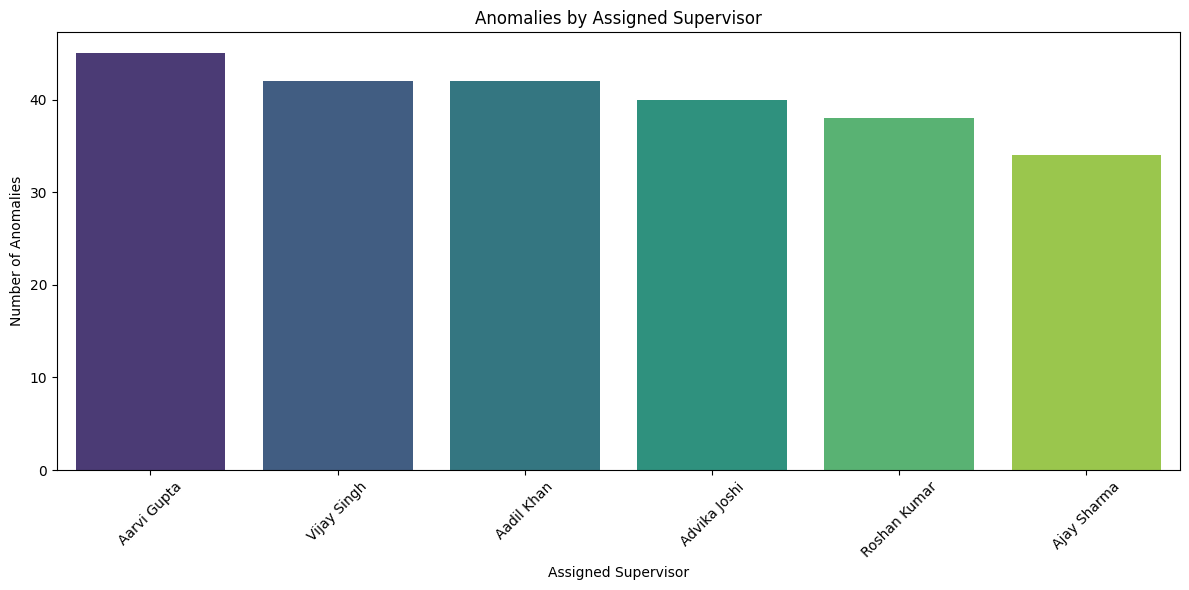

C:\Users\91924\AppData\Local\Temp\ipykernel_21320\113376734.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_anomaly_counts.index, y=product_anomaly_counts.values, palette='coolwarm')


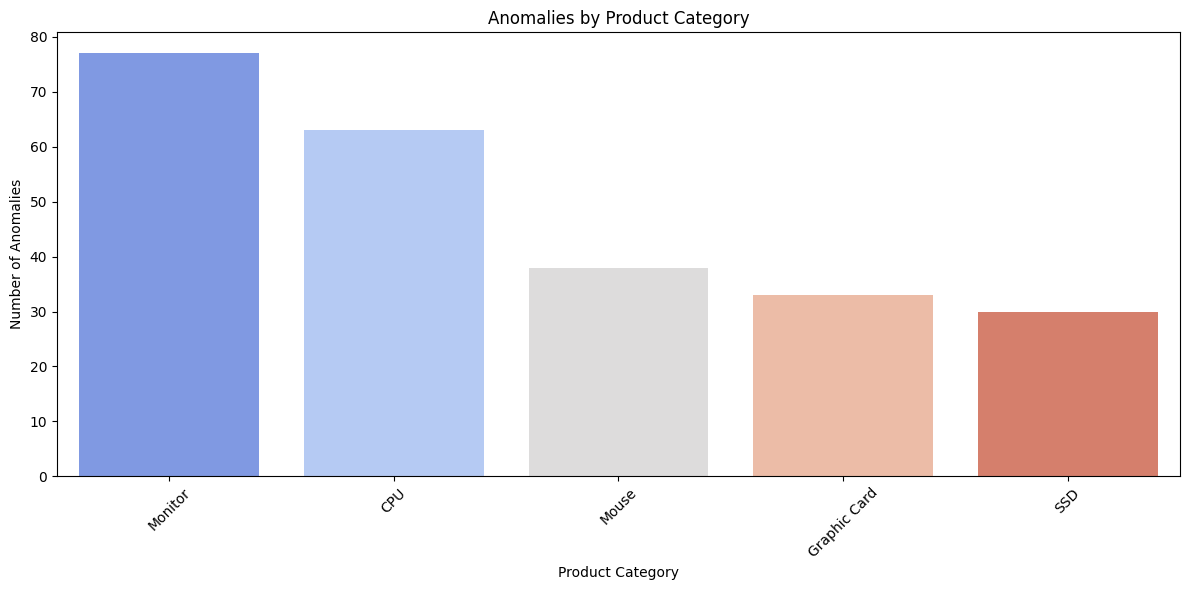

Total Anomalies Detected: 241
Summary of Anomalies:
        Order_Number                     Order_Date          Cost  \
count     241.000000                            241    241.000000   
mean   141954.975104  2021-06-15 04:58:45.311203328  10593.360996   
min    139396.000000            2020-01-22 00:00:00    350.000000   
25%    140760.000000            2020-09-10 00:00:00  10500.000000   
50%    141909.000000            2021-04-27 00:00:00  12500.000000   
75%    143140.000000            2022-03-30 00:00:00  14500.000000   
max    144462.000000            2022-12-31 00:00:00  14500.000000   
std      1412.182112                            NaN   4671.573779   

              Sales    Quantity    Total_Cost   Total_Sales        Profit  \
count    241.000000  241.000000    241.000000    241.000000    241.000000   
mean   13771.369295    3.385892  40162.240664  52210.912863  12048.672199   
min      455.000000    1.000000    350.000000    455.000000    105.000000   
25%    13650.00000

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import numpy as np

# Load the dataset
df = pd.read_csv(r'C:\Users\91924\Desktop\MY WORKS\sem 7\forensic\project.csv')

# Convert 'Order_Date' to datetime format
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True)

# Ensure numerical columns are correctly formatted
numeric_cols = ['Cost', 'Sales', 'Quantity', 'Total_Cost', 'Total_Sales']

# Convert to numeric and handle errors
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace invalid values with NaN

# Check for any non-numeric entries in numeric columns
non_numeric_counts = df[numeric_cols].isnull().sum()
print("Non-numeric entries in numeric columns:")
print(non_numeric_counts)

# Fill missing values for numeric columns
df.fillna(df[numeric_cols].mean(), inplace=True)

# Create 'Profit' column
df['Profit'] = df['Total_Sales'] - df['Total_Cost']

# Add additional features
df['Sales_to_Cost_Ratio'] = df['Total_Sales'] / (df['Total_Cost'] + 1e-6)  # Avoid division by zero
df['Profit_Margin'] = df['Profit'] / (df['Total_Sales'] + 1e-6)

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination rate
df['Anomaly'] = iso_forest.fit_predict(df[['Total_Cost', 'Total_Sales', 'Profit', 'Sales_to_Cost_Ratio', 'Profit_Margin']])

# Detect anomalies
anomalies = df[df['Anomaly'] == -1]

# Analyze the anomalies by supervisor
supervisor_anomaly_counts = anomalies['Assigned Supervisor'].value_counts()

# Plotting supervisor anomaly distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=supervisor_anomaly_counts.index, y=supervisor_anomaly_counts.values, palette='viridis')
plt.title('Anomalies by Assigned Supervisor')
plt.xlabel('Assigned Supervisor')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze the anomalies by product category
product_anomaly_counts = anomalies['Category'].value_counts()

# Plotting product category anomalies
plt.figure(figsize=(12, 6))
sns.barplot(x=product_anomaly_counts.index, y=product_anomaly_counts.values, palette='coolwarm')
plt.title('Anomalies by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Logging detected anomalies
print(f"Total Anomalies Detected: {len(anomalies)}")
print("Summary of Anomalies:")
print(anomalies.describe())

# Generate a classification report (if you have true labels, otherwise omit this step)
# Assuming you have true labels in 'True_Label' column for evaluation
# print(classification_report(df['True_Label'], df['Anomaly']))

# Saving the anomalies for further analysis if needed
anomalies.to_csv('detected_anomalies.csv', index=False)

# Generate a report summary of anomalies detected
report = anomalies.groupby('Assigned Supervisor').agg({
    'Total_Sales': ['sum', 'mean', 'count'],
    'Total_Cost': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
}).reset_index()

# Save the report to a CSV file
report.columns = ['Assigned Supervisor', 'Total_Sales_Sum', 'Total_Sales_Mean', 'Anomalies_Count', 
                  'Total_Cost_Sum', 'Total_Cost_Mean', 'Profit_Sum', 'Profit_Mean']
report.to_csv('anomaly_report.csv', index=False)
print("Anomaly report generated and saved as 'anomaly_report.csv'.")

# Saving the anomalies for further analysis if needed
anomalies.to_csv(r'C:\Users\91924\Desktop\detected_anomalies.csv', index=False)

# Save the report to a CSV file
report.to_csv(r'C:\Users\91924\Desktop\anomaly_report.csv', index=False)







Detected Anomalies:
      Order_Number State_Code      Customer_Name  Order_Date      Status  \
22        139393.0         OR      Ashish Pandey  22/01/2020  Processing   
58        139427.0         ML       Ashish Kumar  14/02/2020  Processing   
65        139434.0         TN  Jay Prakash Kumar  19/02/2020       Order   
93        139461.0         MP      Ranjeet Kumar   10/3/2020     Shipped   
126       139494.0         GJ        Binod Kumar  21/03/2020       Order   
...            ...        ...                ...         ...         ...   
4964      144323.0         MH      Roshan Zameer  10/12/2022  Processing   
4998      144357.0         WB        Vinod Mehta  22/12/2022     Shipped   
5032      144391.0         TR      Ashish Pandey  27/12/2022  Processing   
5066      144425.0         RJ       Ashish Kumar  31/12/2022     Shipped   
5100      144459.0         NL      Ranjeet Kumar  31/12/2022  Processing   

                         Product      Category   Brand     Cost    

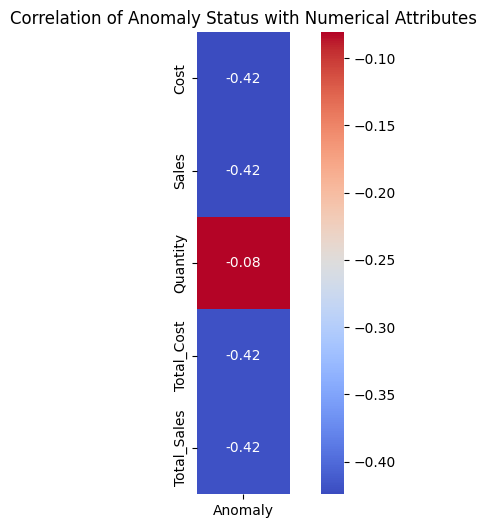

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Load your data
df = pd.read_csv(r'C:\Users\91924\Desktop\MY WORKS\sem 7\forensic\project.csv')  # Update with your actual file path

# Ensure numeric columns are in the correct format
numeric_columns = ['Cost', 'Sales', 'Quantity', 'Total_Cost', 'Total_Sales']  # Your numerical columns
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Calculate Profit
df['Profit'] = df['Total_Sales'] - df['Total_Cost']

# Fill missing values for numeric columns
df.fillna(df[numeric_columns].mean(), inplace=True)

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination rate
df['Anomaly'] = iso_forest.fit_predict(df[numeric_columns])

# Separate anomalies from the original dataframe
anomalies = df[df['Anomaly'] == -1]
print("Detected Anomalies:")
print(anomalies)

# Saving the anomalies for further analysis if needed
anomalies.to_csv(r'C:\Users\91924\Desktop\detected_anomalies.csv', index=False)

# Create a report of the anomalies
report = anomalies.describe()
print("Anomaly Report:")
print(report)

# Save the report to a CSV file
report.to_csv(r'C:\Users\91924\Desktop\anomaly_report.csv', index=False)

# Create a correlation matrix between anomalies and all numeric attributes
correlation_matrix = df[numeric_columns + ['Anomaly']].corr()

# Filtering correlation values for the anomalies
anomalies_correlation = correlation_matrix.loc[numeric_columns, 'Anomaly']

# Create a correlation map for anomalies
plt.figure(figsize=(8, 6))
sns.heatmap(anomalies_correlation.to_frame(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation of Anomaly Status with Numerical Attributes')
plt.show()


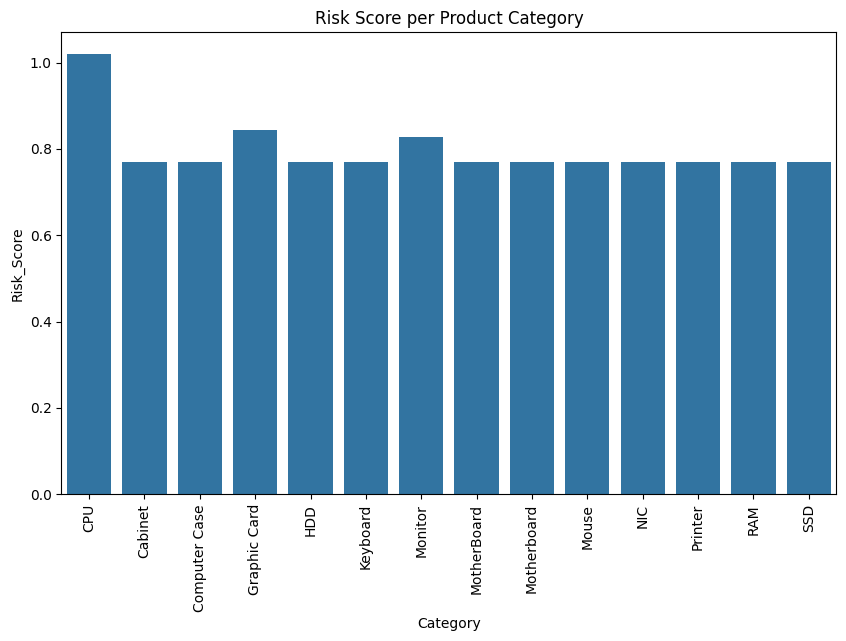


Product categories with the highest risk of anomalies:
        Category  Anomaly  Risk_Score
0            CPU      150    1.019231
3   Graphic Card       33    0.842564
6        Monitor       44    0.827976
1        Cabinet        0    0.769231
2  Computer Case        0    0.769231


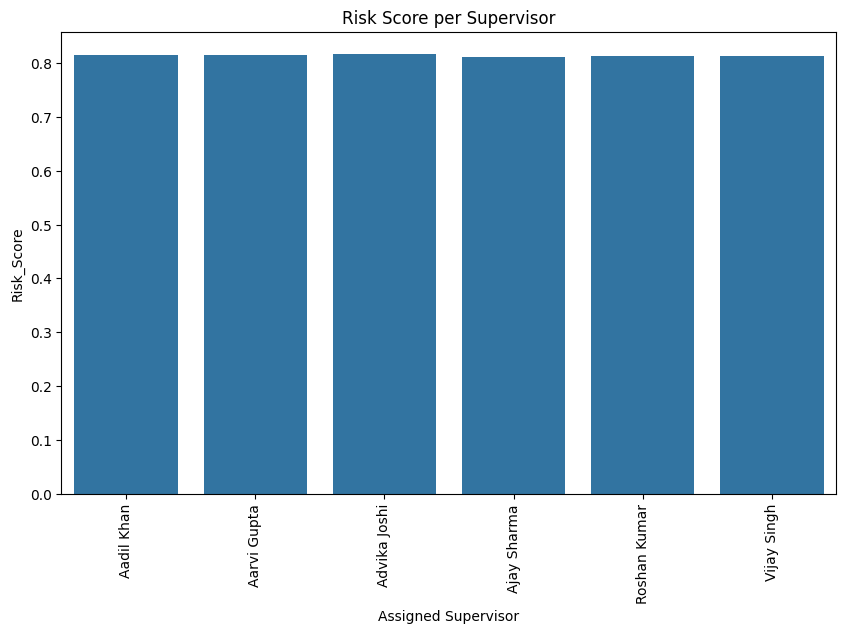

Supervisors with the highest risk of anomalies:
  Assigned Supervisor  Anomaly  Risk_Score
2        Advika Joshi       38    0.817271
1         Aarvi Gupta       44    0.814732
0          Aadil Khan       36    0.814400
5         Vijay Singh       35    0.813311
4        Roshan Kumar       35    0.813090

Products with the highest risk of anomalies:
                         Product  Anomaly  Risk_Score
1068  I7 - intel 12th Generation      150    1.769231
371              26" LCD Display       44    1.062564
641             4GB Graphic card       33    0.989231
0                       1 TB SSD        0    0.769231
817                   619 GB M.2        0    0.769231
Risk Score of Standard ATX motherboard: 0.769230769230769
Assigned Supervisor: Advika Joshi


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = r"C:\Users\91924\Desktop\MY WORKS\sem 7\forensic\project.csv"
df = pd.read_csv(file_path)
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True)

df = df.dropna()  # Remove missing values

# Feature Engineering
# Calculate profit margin as a basic financial metric
df['Profit'] = df['Total_Sales'] - df['Total_Cost']
df['Profit_Margin'] = df['Profit'] / df['Total_Sales']

# Grouping Supervisor performance based on the total sales and profit margin
supervisor_performance = df.groupby('Assigned Supervisor').agg({
    'Total_Sales': 'sum',
    'Profit_Margin': 'mean',
    'Order_Number': 'count'
}).rename(columns={'Order_Number': 'Total_Orders'}).reset_index()

# Merge supervisor performance back to the main dataframe
df = pd.merge(df, supervisor_performance, on='Assigned Supervisor', how='left', suffixes=('', '_supervisor'))

# Anomaly detection using Isolation Forest
features = ['Total_Sales', 'Profit_Margin', 'Cost', 'Quantity']  # Financial metrics
X = df[features]

# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(X)

# Mark anomalies
df['Anomaly'] = df['Anomaly_Score'].apply(lambda x: 1 if x == -1 else 0)

# Risk Score: Combine supervisor performance with anomaly detection
df['Risk_Score'] = df['Anomaly'] + (1 - df['Profit_Margin_supervisor'])

# Supervisor-level risk aggregation
supervisor_risk = df.groupby('Assigned Supervisor').agg({
    'Anomaly': 'sum',
    'Risk_Score': 'mean'
}).reset_index()

# Product-level risk aggregation
product_risk = df.groupby('Product').agg({
    'Anomaly': 'sum',  # Total anomalies per product
    'Risk_Score': 'mean'
}).reset_index()

# Product category-level risk aggregation
category_risk = df.groupby('Category').agg({
    'Anomaly': 'sum',  # Total anomalies per category
    'Risk_Score': 'mean'
}).reset_index()

# Function to assign supervisor based on product name or product category
def assign_supervisor(df):
    product_name = input("Enter the product name (or leave blank to enter category): ").strip()
    product_category = input("Enter the product category (or leave blank to use product name): ").strip()

    # Check if either product_name or product_category is provided
    if product_name:
        product_data = df[df['Product'] == product_name]
    elif product_category:
        product_data = df[df['Category'] == product_category]
    else:
        print("Please provide either a product name or product category.")
        return
    
    if product_data.empty:
        print("No data found for the given product name or category.")
        return

    # Calculate the risk score for the selected products
    product_risk_score = product_data['Risk_Score'].mean()
    print(f"Risk Score of {product_name or product_category}: {product_risk_score}")

    # Logic to assign supervisor based on product risk score
    if product_risk_score < 0.9:
        # Assign the supervisor with the highest risk score
        assigned_supervisor = supervisor_risk.loc[supervisor_risk['Risk_Score'].idxmax()]
    else:
        # Assign the supervisor with the lowest risk score
        assigned_supervisor = supervisor_risk.loc[supervisor_risk['Risk_Score'].idxmin()]
    # Display the assigned supervisor details
    print(f"Assigned Supervisor: {assigned_supervisor['Assigned Supervisor']}")

# Visualize product category risk and anomalies
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Risk_Score', data=category_risk)
plt.title('Risk Score per Product Category')
plt.xticks(rotation=90)
plt.show()

# Show categories with the highest probability of anomalies
high_risk_categories = category_risk.sort_values('Risk_Score', ascending=False).head()
print("\nProduct categories with the highest risk of anomalies:")
print(high_risk_categories)

# Visualize supervisor performance and anomalies
plt.figure(figsize=(10, 6))
sns.barplot(x='Assigned Supervisor', y='Risk_Score', data=supervisor_risk)
plt.title('Risk Score per Supervisor')
plt.xticks(rotation=90)
plt.show()

# Show supervisors with highest probability of anomalies
high_risk_supervisors = supervisor_risk.sort_values('Risk_Score', ascending=False).head()
print("Supervisors with the highest risk of anomalies:")
print(high_risk_supervisors)

# Show products with the highest probability of anomalies
high_risk_products = product_risk.sort_values('Risk_Score', ascending=False).head()
print("\nProducts with the highest risk of anomalies:")
print(high_risk_products)

# Call the supervisor assignment function
assign_supervisor(df)


In [ ]:
# Example usage of the supervisor assignment function
assign_supervisor(df, product_name="Standard ATX motherboard")  # Replace with your desired product name
# or
assign_supervisor(df, product_category="CPU")  